In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings  # 异常拦截

import sklearn
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.linear_model.coordinate_descent import ConvergenceWarning

In [4]:
# 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
# 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

##### 1、创建模拟数据

In [5]:
np.random.seed(100)   # seed() 种子号

N = 10   # 阶数
x = np.linspace(0, 6, N) + np.random.randn(N)   # 一维行向量[ , , ]
y = 1.8*x**3 + x**2 - 14*x - 7 + np.random.randn(N)

x.shape = (-1,1)   # 或写成 x.shape = -1, 1。转为一维列向量[[],[],[]]  ★★
y.shape = (-1,1)

##### 2、创建管道（四种线性回归算法）

—— RidgeCV(alphas, fit_intercept))    L2-norm

    alphas：正则项的权重，在公式中常写作landa；alpha可以实现对拟合程度的调节
    fit_intercept：表示训练模型需要加一个截距项，默认为True
—— LassoCV(alphas, fit_intercept) L1-norm

    RidgeCV和Ridge的区别是：RidgeCV可以进行交叉验证，获得模型最优参数alpha（theta）  ★
—— ElasticNetCV(alphas, l1_ratio, fit_intercept)

    la_ratio：L1正则项在整个惩罚项中的比例

In [28]:
models = [   # 管道集合是一个列表，管道是一个元组列表
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=False)),
            ('Linear', LinearRegression(fit_intercept=False))   # 普通最小二乘法线性回归
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=False)),
            ('Linear', RidgeCV(alphas=np.logspace(-3,2,50), fit_intercept=False))   # alpha参数可选值是50个，一共会进行50个模型的训练
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=False)),
            ('Linear', LassoCV(alphas=np.logspace(0,1,10), fit_intercept=False))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=False)),
        
            # l1_ratio设置为列表，表示的是在CV交叉验证的过程中，L1正则项占比的可选值
            ('Linear', ElasticNetCV(alphas=np.logspace(0,1,10), l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1], fit_intercept=False))
        ])
]

In [9]:
models = sklearn.pipeline.FeatureUnion([   # 管道集合是一个列表，管道是一个元组列表
            ('Poly1', PolynomialFeatures(include_bias=False)),
            ('Poly2', PolynomialFeatures(include_bias=False)),
])

### 3.1、普通最小二乘法线性回归 拟合图形识别

In [29]:
degree = np.arange(1,N,4) # 1、5、9阶

colors = []
for c in np.linspace(16711680, 255, degree.size):
    colors.append('#%06x' % int(c))
    
model = models[0]

##### 数据预处理 + 模型训练 + 预测 + 评估 + 绘图

1阶，系数为： [30.38156963]
5阶，系数为： [-19.20808111  -0.21353395   3.43106275  -0.38668311   0.02765531]
9阶，系数为： [-1.09417833e+02  1.87727099e+02 -1.13700698e+02 -4.58285718e+00
  3.60553718e+01 -1.73965610e+01  3.82839965e+00 -4.12982505e-01
  1.76546168e-02]


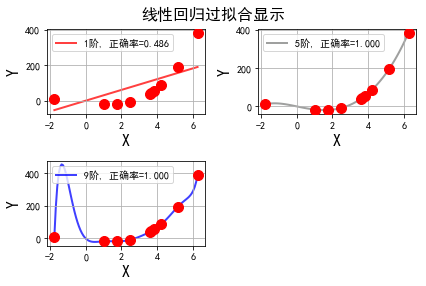

In [30]:
plt.figure(facecolor='w')

for i,d in enumerate(degree):
    plt.subplot(int(np.ceil(degree.size/2.0)),2,i+1)   # 子图排列方式   ★  也可以直接设定 plt.subplot(2,2,i+1)
    plt.plot(x, y, 'ro', ms=10, zorder=N)   # 绘制真实点位置

    # 1、参数设定
    model.set_params(Poly__degree=d,Poly__interaction_only = False)
    # 2、模型训练
    model.fit(x, y.ravel())   # y从（10,1） 经ravel处理后成为 (10, ) 不加ravel好像也可以
    
    #——————————————————————————————————————————————
    lin = model.get_params('Linear')['Linear']   # 输出多项式theta值

        # ______________________________________________________
        # 判断lin对象中是否有对应的属性
    if hasattr(lin, 'alpha_'):
        idx = output.find('系数')   # find() 如果包含子字符串返回开始的索引值。 实际上就是将之前的output赋予的字符加到后面来
        output = output[:idx] + ('alpha=%.6f, ' % lin.alpha_) + output[idx:]   # 从这里可以看出拓展了前面的output
    if hasattr(lin, 'l1_ratio_'):
        idx = output.find('系数')
        output = output[:idx] + ('l1_ratio=%.6f, ' % lin.l1_ratio_) + output[idx:]
        
        # ______________________________________________________
    output = ('%d阶，系数为：' % d)   # 不加（）也可以
    print (output, lin.coef_.ravel())
    #——————————————————————————————————————————————
    
    x_test = np.linspace(x.min(), x.max(), num=100) # 产生测试数据
    x_test.shape = (-1,1)
    y_predict = model.predict(x_test)   # 3、预测
    s = model.score(x, y)   # 4、计算评估值 R^2
    
    z = N - 1 if (d == 2) else 0
    label = '%d阶, 正确率=%.3f' % (d,s)
    plt.plot(x_test, y_predict, color=colors[i], linewidth=2, alpha=0.75, label=label, zorder=z)
    
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)

plt.tight_layout(1, rect=(0,0,1,0.95))   # 控制多图形布局 —— rect 图形与图像边界距离
plt.suptitle('线性回归过拟合显示', fontsize=16)
plt.show()

### 3.2、线性回归、Lasso回归、Ridge回归、ElasticNet比较

In [18]:
plt.figure(facecolor='w')
degree = np.arange(1,N,2)
dm = degree.size

colors = [] # 颜色
for c in np.linspace(16711680, 255, dm):
    colors.append('#%06x' % int(c))
    
titles = ['线性回归', 'Ridge回归', 'Lasso回归', 'ElasticNet']

<Figure size 432x288 with 0 Axes>

线性回归:1阶，系数为： [30.38156963]
线性回归:3阶，系数为： [-13.79947972  -0.22559096   1.96459255]
线性回归:5阶，系数为： [-19.20808111  -0.21353395   3.43106275  -0.38668311   0.02765531]
线性回归:7阶，系数为： [-2.29045262e+01  2.55148389e+00  3.97385058e+00 -1.21202144e+00
  2.49641776e-01 -2.26092204e-02  7.31397622e-04]
线性回归:9阶，系数为： [-1.09417833e+02  1.87727099e+02 -1.13700698e+02 -4.58285718e+00
  3.60553718e+01 -1.73965610e+01  3.82839965e+00 -4.12982505e-01
  1.76546168e-02]
Ridge回归:1阶，系数为： [29.87629065]
Ridge回归:3阶，系数为： [-12.98191422  -0.50844765   1.98772916]
Ridge回归:5阶，系数为： [-18.76655299  -0.28947771   3.32509764  -0.35027493   0.02456046]
Ridge回归:7阶，系数为： [-1.73464089e+01 -3.48657706e+00  4.33150776e+00  3.97292051e-01
 -4.51043233e-01  8.99449634e-02 -5.62271893e-03]
Ridge回归:9阶，系数为： [-2.2521578  -2.27937783 -1.70299005 -1.0348803   0.85755012  0.37020601
 -0.26024292  0.04709033 -0.00277978]
Lasso回归:1阶，系数为： [30.30898284]
Lasso回归:3阶，系数为： [-12.31558512  -0.50643475   1.96415216]
Lasso回归:5阶，系数为： [-1.24909594e+01 -5

C:\4_IT\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\4_IT\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\4_IT\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\4_IT\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will cha

 [-1.27811183e+01 -4.98829790e-01  1.80841074e+00  3.63112522e-02
  3.58085019e-03 -3.10903060e-04 -3.41734781e-05 -4.79387182e-06
 -4.44359649e-07]
ElasticNet:1阶，系数为： [28.51169563]
ElasticNet:3阶，系数为： [-10.72359515  -1.20646101   2.03645101]
ElasticNet:5阶，系数为： [-5.90338414 -1.62213355  1.13077809  0.2390498  -0.01640652]


C:\4_IT\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\4_IT\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNet:7阶，系数为： [-0.00000000e+00 -5.01937000e-01 -5.19301358e-01  4.23051981e-01
  9.92333700e-03 -9.67612191e-04 -4.10033277e-04]
ElasticNet:9阶，系数为： [-5.99808906e-01 -5.30280006e-01 -4.90332274e-01  4.06755276e-01
  8.48508256e-03  9.01175104e-06 -1.61866235e-04 -2.56224768e-05
 -3.78971558e-06]


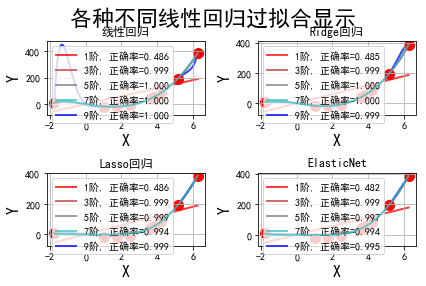

In [21]:
for t in range(4):
    model = models[t]   # 选择模型(线性、Lasso、Ridge、EN)
    plt.subplot(2,2,t+1)   # 创建子图布局
    plt.plot(x, y, 'ro', ms=10, zorder=1)  # 在子图中画原始数据点； zorder：图像显示在第几层

    for i,d in enumerate(degree):   # 遍历不同的多项式的阶，看不同阶的情况下，模型的效果
        
        model.set_params(Poly__degree=d)   # 设置多项式阶数
        model.fit(x, y.ravel())   # 模型训练。可理解成训练后的模型存储在model中，再通过model调用预测和评估

        x_test = np.linspace(x.min(), x.max(), num=100) # 产生测试数据
        x_test.shape = (-1,1)
        
        y_predict = model.predict(x_test)   # 预测
        s = model.score(x, y)   # 数据评估 —— 因为此部分数据没有测试集X_test和Y_test，所以只能评估训练集；
                                # 今后对自定义数据进行评估时，都是用训练集进行评估

        z = N - 1 if (d == 7) else 0   # 突出显示阶层为7的曲线
        label = u'%d阶, 正确率=%.3f' % (d,s)
        plt.plot(x_test, y_predict, color=colors[i], linewidth=2, alpha=0.75, label=label, zorder=z)   # 绘制预测值曲线
    
        #——————————————————————————————————————————————
        lin = model.get_params('Linear')['Linear']

        output = '%s:%d阶，系数为：' % (titles[t],d)
        print (output, lin.coef_.ravel())   # 输出xi的系数，即theata值；并使用ravel()降为一维
        #——————————————————————————————————————————————
        
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.title(titles[t])
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)
    
plt.tight_layout(1, rect=(0,0,1,0.95))   # 子图间隔
plt.suptitle('各种不同线性回归过拟合显示', fontsize=22)
plt.show()